In [3]:
import os
import re
import numpy as np
from optparse import OptionParser

In [4]:
def kpath_name_parse(KPATH_STR):
    '''
    Parse the kpath string
    '''

    KPATH_STR = KPATH_STR.upper()
    # legal kpath separators: blank space, comma, hypen or semicolon
    KPATH_SEPARATORS = ' ,-;'
    # Greek Letters Dictionaries
    GREEK_KPTS = {
        'G':      r'$\mathrm{\mathsf{\Gamma}}$',
        'GAMMA':  r'$\mathrm{\mathsf{\Gamma}}$',
        'DELTA':  r'$\mathrm{\mathsf{\Delta}}$',
        'LAMBDA': r'$\mathrm{\mathsf{\Lambda}}$',
        'SIGMA':  r'$\mathrm{\mathsf{\Sigma}}$',
    }

    # If any of the kpath separators is in the kpath string
    if any([s in KPATH_STR for s in KPATH_SEPARATORS]):
        kname = [
            GREEK_KPTS[x] if x in GREEK_KPTS else 
	    r'$\mathrm{{\mathsf{{{}}}}}$'.format(x)
            for x in re.sub('['+KPATH_SEPARATORS+']', ' ', KPATH_STR).split()
        ]
    else:
        kname = [
            GREEK_KPTS[x] if x in GREEK_KPTS else 
	    r'$\mathrm{{\mathsf{{{}}}}}$'.format(x)
            for x in KPATH_STR
        ]

    return kname

In [5]:
def parseList(string):
    def parseRange(rng):
        # print(rng)
        m = re.match(r'(\d+)(?:[-:](\d+))?(?:[-:](\d+))?$', rng)
        if not m:
            raise ValueError(
                """
The index should be assigned with combination of the following ways:
-> 10, a single band with index 10
-> 20:30, or '20-30', a continuous range from 20 to 30, 30 included
-> 30:50:2, or '30-50:2', a continues range from 30 to 50, with step size 2
-> '1 2 3', all the patterns above in one string separated by spaces.
For example: '1 4:6 8:16:2' will be converted to '1 4 5 6 8 10 12 14 16'
"""
            )
        ii = m.group(1)
        jj = m.group(2) or ii
        ss = m.group(3) or 1
        return [x-1 for x in range(int(ii), int(jj)+1, int(ss))]

    ret = []
    for rng in string.split():
        ret += parseRange(rng)
    return list(set(ret))

def parseSpdProjection(spd):
    '''
    Parse spdProjections string.  str -> [int]

    # Ionizing
    '''
    spd_dict = {
            's'   : [0],
            'p'   : [1, 2, 3],
            'd'   : [4, 5, 6, 7, 8],
            'f'   : [9, 10, 11, 12, 13, 14, 15],
            'py'  : [1],
            'pz'  : [2],
            'px'  : [3],
            'dxy' : [4],
            'dyz' : [5],
            'dz2' : [6],
            'dxz' : [7],
            'dx2' : [8],
    "fy(3x2-y2)"  : [9],
    "fxyz  "      : [10],
    "fyz2  "      : [11],
    "fz3   "      : [12],
    "fxz2  "      : [13],
    "fz(x2-y2)"   : [14],
    "fx(x2-3y2) " : [15],
    }

    ret = []
    for l in spd.split():
        try:
            assert int(l) <= 15, "Maximum spd index should be <= 15."
            ret += [int(l)]
        except:
            if l.lower() not in spd_dict:
                raise ValueError(
                   "Spd-projected wavefunction character of each KS orbital.\n"
                   "    s orbital: 0\n"
                   "    py, pz, px orbital: 1 2 3\n"
                   "    dxy, dyz, dz2, dxz, dx2 orbital: 4 5 6 7 8 \n"
                   "    fy(3x2-y2), fxyz, fyz2, fz3, fxz2, fz(x2-y2), fx(x2-3y2) orbital: 9 10 11 12 13 14 15\n"
                   "\nFor example, --spd 's dxy 10' specifies the s/dxy/fxyz components\n"
                )
            ret += spd_dict[l]

    return list(set(ret))

In [6]:
def command_line_arg():
    usage = "usage: %prog [options] arg1 arg2"
    par = OptionParser(usage=usage, version=__version__)

    par.add_option('-f', '--file',
                   action='store', type="string",
                   dest='filename', default='OUTCAR',
                   help='location of OUTCAR')

    par.add_option('--procar',
                   action='store', type="string", dest='procar',
                   default='PROCAR',
                   help='location of the PROCAR')

    par.add_option('-z', '--zero',
                   action='store', type="float",
                   dest='efermi', default=None,
                   help='energy reference of the band plot')

    par.add_option('-o', '--output',
                   action='store', type="string", dest='bandimage',
                   default='band.png',
                   help='output image name, "band.png" by default')

    par.add_option('-k', '--kpoints',
                   action='store', type="string", dest='kpts',
                   default=None,
                   help='kpoint path, use ",", " ", ";" or "-" to separate the K-point if necessary.')

    par.add_option('--hse',
                   action='store_true', dest='isHSE',
                   default=False,
                   help='whether the calculation is HSE')

    par.add_option('--skip_kpts',
                   action='store', type="string", dest='skip_kpts',
                   default=None,
                   help='Skip the bands of the redundant k-points, usefull in HSE band plot.')

    par.add_option('--nseg',
                   action='append', type="int", dest='nseg',
                   default=[],
                   help='Number of kpoints in each segment, used with --skip_kpts.')

    par.add_option('-s', '--size', nargs=2,
                   action='store', type="float", dest='figsize',
                   default=(3.0, 4.0),
                   help='figure size of the output plot')

    par.add_option('-y', nargs=2,
                   action='store', type="float", dest='ylim',
                   default=(-3, 3),
                   help='energy range of the band plot')

    par.add_option('--hline',
                   action='append', type="float", dest='hlines',
                   default=[],
                   help='Add horizontal lines to the figure.')

    par.add_option('--vline',
                   action='append', type="float", dest='vlines',
                   default=[],
                   help='Add vertical lines to the figure.')

    par.add_option('--save_gnuplot',
                   action='store_true', dest='gnuplot',
                   default=False,
                   help='save output band energies in gnuplot format')

    par.add_option('--lw',
                   action='store', type="float", dest='linewidth',
                   default=1.0,
                   help='linewidth of the band plot')

    par.add_option('--lc',
                   action='store', type="str", dest='linecolors',
                   default=None,
                   help='line colors of the band plot')

    par.add_option('--dpi',
                   action='store', type="int", dest='dpi',
                   default=360,
                   help='resolution of the output image')

    par.add_option('--occ',
                   action='append', type="string", dest='occ',
                   default=[],
                   help='orbital contribution of each KS state')

    par.add_option('--occL',
                   action='store_true', dest='occLC',
                   default=False,
                   help='use Linecollection or Scatter to show the orbital contribution')

    par.add_option('--occLC_cmap',
                   action='store', type='string', dest='occLC_cmap',
                   default='jet',
                   help='colormap of the line collection')

    par.add_option('--occLC_lw',
                   action='store', type='float', dest='occLC_lw',
                   default=2.0,
                   help='linewidth of the line collection')

    par.add_option('--occLC_cbar_pos',
                   action='store', type='string', dest='occLC_cbar_pos',
                   default='top',
                   help='position of the colorbar')

    par.add_option('--occLC_cbar_ticks',
                   action='store', type='string', dest='occLC_cbar_ticks',
                   default=None,
                   help='ticks for the colorbar')

    par.add_option('--occLC_cbar_vmin',
                   action='store', type='float', dest='occLC_cbar_vmin',
                   default=None,
                   help='minimum value for the color plot')

    par.add_option('--occLC_cbar_vmax',
                   action='store', type='float', dest='occLC_cbar_vmax',
                   default=None,
                   help='maximum value for the color plot')

    par.add_option('--occLC_cbar_ticklabels',
                   action='store', type='string', dest='occLC_cbar_ticklabels',
                   default=None,
                   help='tick labels for the colorbar')

    par.add_option('--occLC_cbar_size',
                   action='store', type='string', dest='occLC_cbar_size',
                   default='3%',
                   help='size of the colorbar, relative to the axis')

    par.add_option('--occLC_cbar_pad',
                   action='store', type='float', dest='occLC_cbar_pad',
                   default=0.02,
                   help='pad between colorbar and axis')

    par.add_option('--occM',
                   action='append', type="string", dest='occMarker',
                   default=[],
                   help='the marker used in the plot')

    par.add_option('--occMs',
                   action='append', type="int", dest='occMarkerSize',
                   default=[],
                   help='the size of the marker')

    par.add_option('--occMc',
                   action='append', type="string", dest='occMarkerColor',
                   default=[],
                   help='the color of the marker')

    par.add_option('--spd',
                   action='append', type="string", dest='spdProjections',
                   default=[],
                   help='Spd-projected wavefunction character of each KS orbital.')

    par.add_option('--spin', action='store', dest='spin',
                   default=None, choices=['x', 'y', 'z'],
                   help='show the magnetization mx/y/z constributions to the states. Use this option along with --occ.')

    par.add_option('--lsorbit',
                   action='store_true', dest='lsorbit',
                   help='Spin orbit coupling on, special treament of PROCAR')

    par.add_option('-q', '--quiet',
                   action='store_true', dest='quiet',
                   help='not show the resulting image')

    return par.parse_args()

In [7]:
def get_bandInfo(inFile='OUTCAR'):
    """
    extract band energies from OUTCAR
    """

    outcar = [line for line in open(inFile) if line.strip()]

    for ii, line in enumerate(outcar):
        if 'NKPTS =' in line:
            nkpts = int(line.split()[3])                                # getting a value 
            nband = int(line.split()[-1])

        if 'ISPIN  =' in line:
            ispin = int(line.split()[2])

        if "k-points in reciprocal lattice and weights" in line:
            Lvkpts = ii + 1                                             # getting the index

        if 'reciprocal lattice vectors' in line:
            ibasis = ii + 1

        if 'E-fermi' in line:
            Efermi = float(line.split()[2])
            LineEfermi = ii + 1
            # break

    # basis vector of reciprocal lattice
    # B = np.array([line.split()[3:] for line in outcar[ibasis:ibasis+3]],

    # When the supercell is too large, spaces are missing between real space
    # lattice constants. A bug found out by Wei Xie (weixie4@gmail.com).
    B = np.array([line.split()[-3:] for line in outcar[ibasis:ibasis+3]],
                 dtype=float)
    # k-points vectors and weights
    tmp = np.array([line.split() for line in outcar[Lvkpts:Lvkpts+nkpts]],
                   dtype=float)
    vkpts = tmp[:, :3]
    wkpts = tmp[:, -1]

    # for ispin = 2, there are two extra lines "spin component..."
    N = (nband + 2) * nkpts * ispin + (ispin - 1) * 2

    # in VASP 6.2, there is extra lines containing "Fermi energy: xxxx"
    if 'Fermi energy:' in outcar[LineEfermi]:
        N += ispin

    bands = []
    # vkpts = []
    for line in outcar[LineEfermi:LineEfermi + N]:
        if 'spin component' in line or 'band No.' in line:
            continue
        if 'Fermi energy:' in line:
            continue
        if 'k-point' in line:
            # vkpts += [line.split()[3:]]
            continue
        bands.append(float(line.split()[1]))

    bands = np.array(bands, dtype=float).reshape((ispin, nkpts, nband))

    if os.path.isfile('KPOINTS'):
        kp = open('KPOINTS').readlines()

    if os.path.isfile('KPOINTS') and kp[2][0].upper() == 'L':
        Nk_in_seg = int(kp[1].split()[0])
        Nseg = nkpts // Nk_in_seg
        vkpt_diff = np.zeros_like(vkpts, dtype=float)

        for ii in range(Nseg):
            start = ii * Nk_in_seg
            end = (ii + 1) * Nk_in_seg
            vkpt_diff[start:end, :] = vkpts[start:end, :] - vkpts[start, :]

        kpt_path = np.linalg.norm(np.dot(vkpt_diff, B), axis=1)
        # kpt_path = np.sqrt(np.sum(np.dot(vkpt_diff, B)**2, axis=1))
        for ii in range(1, Nseg):
            start = ii * Nk_in_seg
            end = (ii + 1) * Nk_in_seg
            kpt_path[start:end] += kpt_path[start-1]

        # kpt_path /= kpt_path[-1]
        kpt_bounds = np.concatenate((kpt_path[0::Nk_in_seg], [kpt_path[-1], ]))
    else:
        # get band path
        vkpt_diff = np.diff(vkpts, axis=0)
        kpt_path = np.zeros(nkpts, dtype=float)
        kpt_path[1:] = np.cumsum(np.linalg.norm(np.dot(vkpt_diff, B), axis=1))
        # kpt_path /= kpt_path[-1]

        # get boundaries of band path
        xx = np.diff(kpt_path)
        kpt_bounds = np.concatenate(
            ([0.0, ], kpt_path[1:][np.isclose(xx, 0.0)], [kpt_path[-1], ]))

    return kpt_path, bands, Efermi, kpt_bounds, wkpts

In [8]:
def bandplot(kpath, bands, efermi, kpt_bounds, opts, whts=None):
    '''
    Use matplotlib to plot band structure
    '''

    width, height = opts.figsize
    ymin, ymax = opts.ylim
    dpi = opts.dpi

    fig = plt.figure()
    fig.set_size_inches(width, height)
    ax = plt.subplot(111)

    nspin, nkpts, nbands = bands.shape

    clrs = ['r', 'b']

    if opts.occLC and (whts is not None):
        from matplotlib.collections import LineCollection
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        LW = opts.occLC_lw
        DELTA = 0.3
        EnergyWeight = whts[0]
        norm = mpl.colors.Normalize(
                vmin = opts.occLC_cbar_vmin if opts.occLC_cbar_vmin else EnergyWeight.min(),
                vmax = opts.occLC_cbar_vmax if opts.occLC_cbar_vmax else EnergyWeight.max(),
        )
        # norm = mpl.colors.Normalize(0, 1)
        # create a ScalarMappable and initialize a data structure
        s_m = mpl.cm.ScalarMappable(cmap=opts.occLC_cmap, norm=norm)
        s_m.set_array([EnergyWeight])

        for Ispin in range(nspin):

            # If x and/or y are 2D arrays a separate data set will be drawn for
            # every column. If both x and y are 2D, they must have the same
            # shape. If only one of them is 2D with shape (N, m) the other must
            # have length N and will be used for every data set m.

            ax.plot(kpath, bands[Ispin],
                    lw=LW + 2 * DELTA,
                    color='gray', zorder=1)

            for jj in range(nbands):
                x = kpath
                y = bands[Ispin, :, jj]
                z = EnergyWeight[Ispin, :, jj]

                # ax.plot(x, y,
                #         lw=LW + 2 * DELTA,
                #         color='gray', zorder=1)

                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments,
                                    # cmap=opts.occLC_cmap, # alpha=0.7,
                                    colors=[s_m.to_rgba(ww)
                                            for ww in (z[1:] + z[:-1])/2.]
                                    # norm=plt.Normalize(0, 1)
                                    )
                # lc.set_array((z[1:] + z[:-1]) / 2)
                lc.set_linewidth(LW)
                ax.add_collection(lc)

        divider = make_axes_locatable(ax)
        ax_cbar = divider.append_axes(opts.occLC_cbar_pos.lower(),
                                      size=opts.occLC_cbar_size, pad=opts.occLC_cbar_pad)

        if opts.occLC_cbar_pos.lower() == 'top' or opts.occLC_cbar_pos.lower() == 'bottom':
            ori = 'horizontal'
        else:
            ori = 'vertical'
        cbar = plt.colorbar(s_m, cax=ax_cbar,
                            # ticks=[0.0, 1.0],
                            orientation=ori)
        if opts.occLC_cbar_ticks:
            cbar.set_ticks([
                float(x) for x in
                opts.occLC_cbar_ticks.split()
            ])
            if opts.occLC_cbar_ticklabels:
                cbar.set_ticklabels(opts.occLC_cbar_ticklabels.split())

        if ori == 'horizontal':
            cbar.ax.xaxis.set_ticks_position('top')
        else:
            cbar.ax.yaxis.set_ticks_position('right')


    else:
        for Ispin in range(nspin):
            # If x and/or y are 2D arrays a separate data set will be drawn for
            # every column. If both x and y are 2D, they must have the same
            # shape. If only one of them is 2D with shape (N, m) the other must
            # have length N and will be used for every data set m.
            ax.plot(kpath, bands[Ispin],
                    lw=opts.linewidth, color=opts.linecolors[Ispin],
                    alpha=0.8, zorder=0)

            if whts is not None:
                kpath_x = np.tile(kpath, (nbands, 1)).T
                for ii in range(len(opts.occ)):
                    ax.scatter(kpath_x, bands[Ispin],
                               color=opts.occMarkerColor[ii],
                               s=whts[ii][Ispin] *
                               opts.occMarkerSize[ii],
                               marker=opts.occMarker[ii], zorder=1, lw=0.0,
                               alpha=0.5)

            # for Iband in range(nbands):
            #     # if Iband == 0 else line.get_color()
            #     lc = opts.linecolors[Ispin]
            #     line, = ax.plot(kpath, bands[Ispin, :, Iband], lw=opts.linewidth, zorder=0,
            #                     alpha=0.8,
            #                     color=lc,
            #                     )
            #     if whts is not None:
            #         for ii in range(len(opts.occ)):
            #             ax.scatter(kpath, bands[Ispin, :, Iband],
            #                        color=opts.occMarkerColor[ii],
            #                        s=whts[ii][Ispin, :, Iband] *
            #                        opts.occMarkerSize[ii],
            #                        marker=opts.occMarker[ii], zorder=1, lw=0.0,
            #                        alpha=0.5)

    for bd in kpt_bounds:
        ax.axvline(x=bd, ls='-', color='k', lw=0.5, alpha=0.5)

    # add extra horizontal/vertical lines
    for xx in opts.hlines:
        ax.axhline(y=xx, ls=':', color='k', lw=0.5, alpha=0.5)
    for yy in opts.vlines:
        ax.axvline(x=yy, ls=':', color='k', lw=0.5, alpha=0.5)

    ax.set_ylabel('Energy [eV]',  # fontsize='small',
                  labelpad=5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(kpath.min(), kpath.max())

    ax.set_xticks(kpt_bounds)
    if opts.kpts:
        ax.set_xticklabels(kpath_name_parse(opts.kpts))
    else:
        ax.set_xticklabels([])

    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    plt.tight_layout(pad=0.20)
    plt.savefig(opts.bandimage, dpi=opts.dpi)

############################################################


def saveband_dat(kpath, bands, opts, whts=None):
    '''
    save band info to txt files
    '''
    prefix = 'pyband'
    spinSuffix = ['up', 'do']
    nspin, nkpts, nbands = bands.shape

    if nspin == 1:
        if opts.gnuplot:
            with open(prefix + '.dat', 'w') as out:
                #line = "kpts      energy      [projection weight]"
                for jj in range(nbands):
                    line = ''
                    for ii in range(nkpts):
                        line = ''
                        line += '%8.4f ' % kpath[ii]
                        line += '%10.4f' % bands[0, ii, jj]
                        line += '\n'
                        out.write(line)
                    line = '\n'
                    out.write(line)
                line = '\n'
                out.write(line)
                if opts.occ:
                    for kk in range(len(opts.occ)):
                        for jj in range(nbands):
                            line = ''
                            for ii in range(nkpts):
                                line = ''
                                line += '%8.4f ' % kpath[ii]
                                line += '%10.4f ' % bands[0, ii, jj]
                                line += '%10.4f' % whts[kk][0, ii, jj]
                                line += '\n'
                                out.write(line)
                            line = '\n'
                            out.write(line)
                        line = '\n'
                        out.write(line)
        else:
            header = "set xran [{}:{}]\n".format(kpath.min(), kpath.max())
            header += "plot for [ii=2:{}] 'pyband.dat' u 1:ii with line lc rgb '#000' t ''\n".format(
                nbands + 1)
            np.savetxt(prefix + '.dat', np.c_[kpath, bands[0]], fmt='%10.4f',
                       header=header)
            if whts:
                for i in range(len(whts)):
                    np.savetxt(prefix + '_weights_component_{}.dat'.format(i + 1),
                               np.c_[kpath, whts[i][0]], fmt='%10.4f', header=header)

    else:
        if opts.gnuplot:
            for Ispin in range(nspin):
                filename = prefix + '_' + spinSuffix[Ispin] + '.dat'
                with open(filename, 'w') as out:
                    #line = "kpts      energy      [projection weight]"
                    for jj in range(nbands):
                        line = ''
                        for ii in range(nkpts):
                            line = ''
                            line += '%8.4f ' % kpath[ii]
                            line += '%10.4f' % bands[Ispin, ii, jj]
                            line += '\n'
                            out.write(line)
                        line = '\n'
                        out.write(line)
                    line = '\n'
                    out.write(line)
                    if opts.occ:
                        for kk in range(len(opts.occ)):
                            for jj in range(nbands):
                                line = ''
                                for ii in range(nkpts):
                                    line = ''
                                    line += '%8.4f ' % kpath[ii]
                                    line += '%10.4f' % bands[Ispin, ii, jj]
                                    line += '%10.4f' % whts[kk][Ispin, ii, jj]
                                    line += '\n'
                                    out.write(line)
                                line = '\n'
                                out.write(line)
                            line = '\n'
                            out.write(line)
        else:
            for Ispin in range(nspin):
                filename = prefix + '_' + spinSuffix[Ispin] + '.dat'
                header = "set xran [{}:{}]\n".format(kpath.min(), kpath.max())
                header += "plot for [ii=2:{}] '{}' u 1:ii with line lc rgb '#000' t ''\n".format(
                    nbands + 1, filename)
                np.savetxt(filename, np.c_[kpath, bands[Ispin]], fmt='%10.4f',
                           header=header)
                if whts:
                    for i in range(len(whts)):
                        filename = prefix + '_' + spinSuffix[Ispin] + '_weights_component_{}'.format(i + 1) + '.dat'
                        np.savetxt(filename, np.c_[kpath, whts[i][Ispin]], fmt='%10.4f',
                                   header=header)



In [9]:
__version__ = "1.0"

opts, args = command_line_arg()

if opts.occ:
    Nocc  = len(opts.occ)
    occM  = ['o' for ii in range(Nocc)]
    occMc = ['r' for ii in range(Nocc)]
    occMs = [20 for ii in range(Nocc)]
    for ii in range(min(len(opts.occMarker), Nocc)):
        occM[ii] = opts.occMarker[ii]
    for ii in range(min(len(opts.occMarkerSize), Nocc)):
        occMs[ii] = opts.occMarkerSize[ii]
    for ii in range(min(len(opts.occMarkerColor), Nocc)):
        occMc[ii] = opts.occMarkerColor[ii]
    opts.occMarker      = occM
    opts.occMarkerColor = occMc
    opts.occMarkerSize  = occMs

    whts = []
    iterater = 0
    for occ in opts.occ:
        # CCX 2020-01-31 parse input range of atoms
        # if '0' in the index, select all the atoms
        if '0' in occ.split():
            occAtom = None
        else:
            occAtom = parseList(occ)

        if opts.spdProjections:  # and (Nocc == 1):
            if len(opts.spdProjections) != len(opts.occ):
                print("number of projections does not match number of occupations")
                sys.exit(0)

            # set angall to corresponding item of spdProjections
            angularM = parseSpdProjection(opts.spdProjections[iterater])

            whts.append(WeightFromPro(opts.procar, whichAtom=occAtom,
                                        spd=angularM, lsorbit=opts.lsorbit,
                                        spin=opts.spin))
        else:
            whts.append(WeightFromPro(opts.procar, whichAtom=occAtom,
                                        lsorbit=opts.lsorbit,
                                        spin=opts.spin))
        iterater += 1

else:
    whts = None

In [10]:
# kpath, bands, efermi, kpt_bounds, wkpts = get_bandInfo(opts.filename)
kpath, bands, efermi, kpt_bounds, wkpts = get_bandInfo()

In [11]:
# skip the redundant k-points, usefull for HSE band plot
# index starting from 1
if opts.isHSE:
    kmask = np.logical_not(wkpts > 0)
    kpath = kpath[kmask]
    bands = bands[:,kmask,:]
    if whts:
        whts  = [w[:,kmask,...] for w in whts]

    # if opts.nseg is None:
    if len(opts.nseg) == 0:
        raise ValueError("Please enter #kpoints in each kpath segment with '--nseg'.")

    if len(opts.nseg) == 1:
        nn = opts.nseg[0]
        kpt_bounds = np.r_[kpath[::nn], kpath[-1]]
    else:
        kpt_bounds = kpath[opts.nseg]

# skip the redundant k-points, usefull for HSE band plot
# index starting from 1
if opts.skip_kpts:
    skpts = parseList(opts.skip_kpts)
    kmask = [ii for ii in range(bands.shape[1]) if ii not in skpts]
    kpath = kpath[kmask]
    bands = bands[:,kmask,:]
    if whts:
        whts  = [w[:,kmask,...] for w in whts]

    # if opts.nseg is None:
    if len(opts.nseg) == 0:
        raise ValueError("Please enter #kpoints in each kpath segment with '--nseg'.")

    if len(opts.nseg) == 1:
        nn = opts.nseg[0]
        kpt_bounds = np.r_[kpath[::nn], kpath[-1]]
    else:
        kpt_bounds = kpath[opts.nseg]

if opts.efermi is None:
    bands -= efermi
else:
    bands -= opts.efermi

In [12]:
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
# Use non-interactive backend in case there is no display
mpl.use('agg')
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False

mpl_default_colors_cycle = [mpl.colors.to_hex(xx) for xx in
                            mpl.rcParams['axes.prop_cycle'].by_key()['color']]
if opts.linecolors:
    ctmp = [mpl.colors.to_hex(xx) for xx in opts.linecolors.split()]
    nspin = bands.shape[0]
    if len(ctmp) <= nspin:
        opts.linecolors = ctmp + \
            [xx for xx in mpl_default_colors_cycle if xx not in ctmp]
else:
    opts.linecolors = mpl_default_colors_cycle

In [13]:
bandplot(kpath, bands, efermi, kpt_bounds, opts, whts)
saveband_dat(kpath, bands, opts, whts)

In [14]:
nspin, nkpts, nbands = bands.shape
print(f"{nspin=}, {nkpts=}, {nbands=}")

nspin=1, nkpts=90, nbands=48


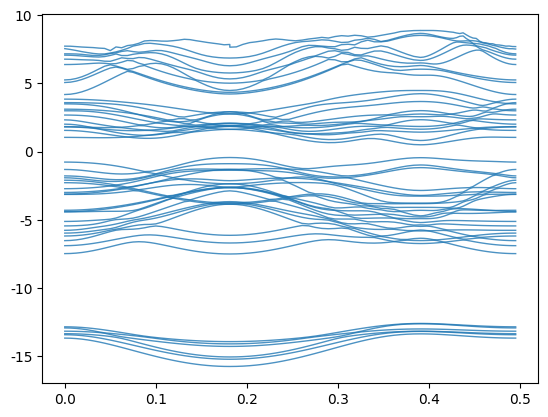

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
ax = plt.subplot(111)
for Ispin in range(nspin):
    # If x and/or y are 2D arrays a separate data set will be drawn for
    # every column. If both x and y are 2D, they must have the same
    # shape. If only one of them is 2D with shape (N, m) the other must
    # have length N and will be used for every data set m.
    plt.plot(kpath, bands[Ispin],
            lw=opts.linewidth, color=opts.linecolors[Ispin],
            alpha=0.8, zorder=0)

plt.show()

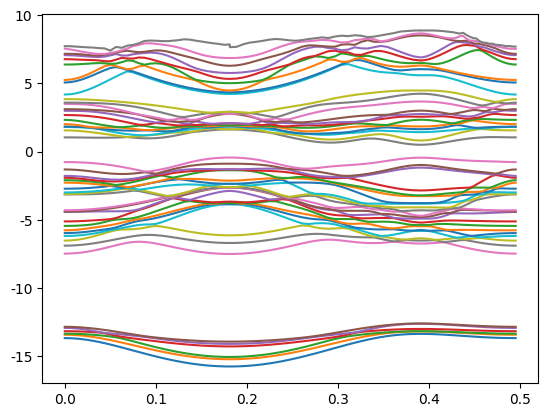

In [32]:
plt.plot(kpath, bands[0])
plt.show()